# importing acl-anthology bib file & creating csv

In [1]:
import requests
import gzip
import shutil
import os

# download anthology file
url = "https://aclanthology.org/anthology+abstracts.bib.gz"
r = requests.get(url)
open('anthology+abstracts.bib.gz', 'wb').write(r.content)

# open and unpack gz
with gzip.open('anthology+abstracts.bib.gz', 'rb') as f_in:
    with open('anthology+abstracts.bib', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
        
os.remove("anthology+abstracts.bib.gz")

In [57]:
# watch out: computes very long
# if you've run this + the following cell once, there should e a csv in your directory
# in that case you can uncomment the cell after the next one and read straight from the csv
import bibtexparser

# parse bib file, output: list of dicts
with open('anthology+abstracts.bib') as bibtex_file:   
    bib_database = bibtexparser.bparser.BibTexParser(common_strings=True).parse_file(bibtex_file)


In [248]:
import pandas as pd
import sre_yield

# define keywords & words to exclude

keywords = ['bias', 'fair', 'protected attribute', 'protected categor']
#for each in sre_yield.AllStrings(r'\b(?:age|bias|biases|ethnic|ethnicity|fair|fairness|race|religion|protected attribute|protected attributes|protected categories|protected category)\b'):
        #keywords.append(each)

excludes = ['hate', 'hate speech']
df = pd.DataFrame()

for paper in bib_database.entries:
    if 'abstract' in paper.keys():
        if any(keyword in paper['abstract'] for keyword in keywords):
            if not any(exclude in paper['abstract'] for exclude in excludes):
                temp_row = {}

                # select only select papers from 2016 on
                if 'year' in paper.keys() and int(paper['year']) >= 2016:

                    for cat in paper.keys():
                        temp_row[cat] = paper[cat]

                    df = df.append(temp_row, ignore_index=True)
        
df.to_csv('bias_paper.csv')

In [142]:
# uncomment if csv is already in directory (and save time parsing the bib file)
import pandas as pd
df = pd.read_csv('bias_paper.csv')

In [249]:
print(df[:10])

       ENTRYTYPE                                ID  \
0  inproceedings       chuang-etal-2021-mitigating   
1  inproceedings          lent-sogaard-2021-common   
2  inproceedings     murayama-etal-2021-mitigation   
3  inproceedings         ghosh-etal-2021-detecting   
4  inproceedings    bertsch-bethard-2021-detection   
5  inproceedings      subramanian-etal-2021-nvidia   
6  inproceedings            wang-etal-2021-tencent   
7  inproceedings      troles-schmid-2021-extending   
8  inproceedings  kumar-etal-2021-learning-feature   
9  inproceedings   dayanik-pado-2021-disentangling   

                                                                                              abstract  \
0  Automatic detection of toxic language plays an essential role in protecting social media users, ...   
1  Large-scale language models such as ELMo and BERT have pushed the horizon of what is possible in...   
2  Fake news causes significant damage to society. To deal with these fake news, severa

# tf-idf & clustering

In [250]:
# inspiration from: https://medium.com/mlearning-ai/text-clustering-with-tf-idf-in-python-c94cd26a31e7

In [251]:
import re
import nltk
from nltk.corpus import stopwords

def preprocess_text(text: str, remove_stopwords: bool) -> str:
    
    # remove links, special characters, numbers, stopwords, whitespaces
    # also remove words that are actually filters
    stopwords_list = stopwords.words("english")
    text = re.sub(r"http\S+", "", text)
    text = re.sub("[^A-Za-z]+", " ", text)
    if remove_stopwords:
        tokens = nltk.word_tokenize(text)
        tokens = [w for w in tokens if not w.lower() in stopwords_list]
        text = " ".join(tokens)
    
    text = text.lower().strip()
    
    return text

In [252]:
# create cleaned column
df['cleaned_w_title'] = df['abstract'].apply(lambda x: preprocess_text(x, remove_stopwords=True)) \
                + df['title'].apply(lambda x: preprocess_text(x, remove_stopwords=True))
df['cleaned_wo_title'] = df['abstract'].apply(lambda x: preprocess_text(x, remove_stopwords=True))

In [253]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.2, max_features=80)
X = vectorizer.fit_transform(df['cleaned_w_title'])
Y = vectorizer.fit_transform(df['cleaned_wo_title'])

In [325]:
print(f'entries: {len(df.index)}')

entries: 1063


In [254]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

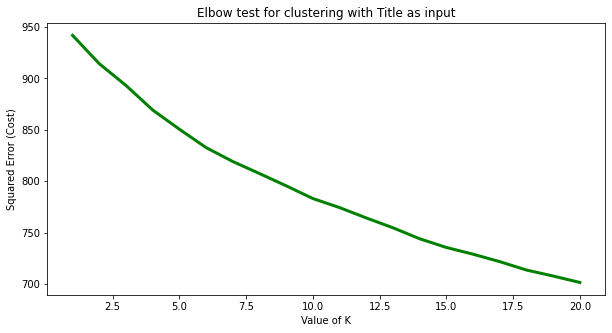

In [256]:
import matplotlib.pyplot as plt
"""
# perform elbow test
cost =[]
for i in range(1, 21):
    kmeans = KMeans(n_clusters = i, max_iter = 500)
    kmeans.fit(X)
     
    # calculates squared error
    # for the clustered points
    cost.append(kmeans.inertia_)    

# plot the cost against K values
plt.plot(range(1, 21), cost, color ='g', linewidth ='3')
plt.title("Elbow test for clustering with Title as input")
plt.xlabel("Value of K")
plt.ylabel("Squared Error (Cost)")
plt.show() # clear the plot
"""

In [310]:
def make_pca_vecs(data, n_clusters=5):
# vary here the number of clusters
    kmeans = KMeans(n_clusters, random_state=42)
    kmeans.fit(data)
    clusters = kmeans.labels_
    # initialize PCA with 2 components
    pca = PCA(n_components=2, random_state=42)
    # pass our X to the pca and store the reduced vectors into pca_vecs
    pca_vecs = pca.fit_transform(data.toarray())
    # save our two dimensions into x0 and x1
    x0 = pca_vecs[:, 0]
    x1 = pca_vecs[:, 1]
    
    return clusters, clusters, x0, x1

In [311]:
# assign clusters and pca vectors to our dataframe 
clusters_df, df['cluster'], df['x0'], df['x1'] = make_pca_vecs(X, n_clusters=4)

In [312]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.options.display.max_colwidth = 100

In [313]:
def get_top_keywords(this_df, data, clusters, n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(data.todense()).groupby(clusters).mean() # groups the TF-IDF vector by cluster
    terms = vectorizer.get_feature_names() # access tf-idf terms
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i+1))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score
            
get_top_keywords(df, X, clusters_df, 20)


Cluster 1
use,used,level,trained,features,across,high,approaches,experiments,nlp,new,quality,analysis,knowledge,systems,metrics,information,languages,existing,natural

Cluster 2
use,corpora,biased,english,experiments,study,first,knowledge,bert,corpus,used,metrics,across,specific,words,trained,representations,nlp,embeddings,generation

Cluster 3
metrics,sentence,used,question,information,test,trained,proposed,linguistic,analysis,system,large,previous,existing,generation,systems,provide,english,many,translation

Cluster 4
well,trained,several,knowledge,level,new,used,find,linguistic,across,use,corpus,research,study,system,biased,detection,specific,method,news


In [314]:
# map clusters to appropriate labels 
cluster_map = {0: "cluster 01", 
               1: "cluster 02", 
               2: "cluster 03", 
               3: "cluster 04", 
               4: "cluster 05", 
               5: "cluster 06", 
              }
# apply mapping
df['cluster'] = df['cluster'].map(cluster_map)

# visualizing outputs

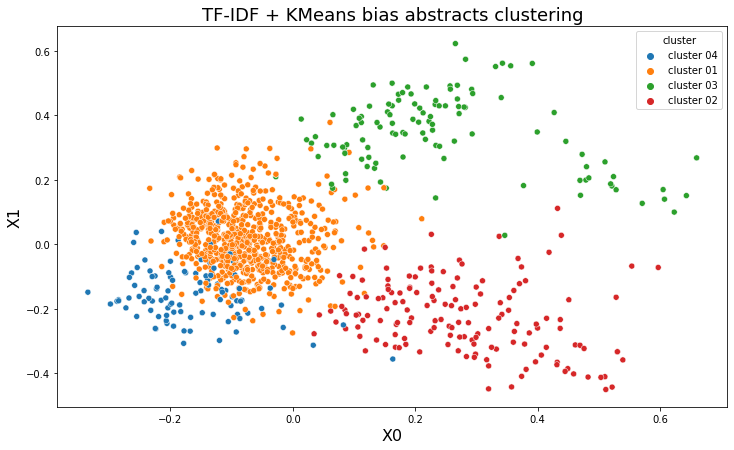

In [315]:
plt.rcParams['figure.figsize'] = [10, 5]
import seaborn as sns

def make_kmeans_plot(this_df):
    # set image size
    plt.figure(figsize=(12, 7))
    plt.title("TF-IDF + KMeans bias abstracts clustering", fontdict={"fontsize": 18})
    # set axes names
    plt.xlabel("X0", fontdict={"fontsize": 16})
    plt.ylabel("X1", fontdict={"fontsize": 16})
    # create scatter plot with seaborn, where hue is the class used to group the data
    sns.scatterplot(data=this_df, x='x0', y='x1', hue='cluster')
    plt.show()
    
make_kmeans_plot(df)

In [353]:
# hand crafted bias list (feel free to change)
bias_list = [' age', ' race', ' gender', ' social', ' ethnic', ' religion']

# ONE HOT ENCODING
def one_hot(val_list, this_df):
    for i in val_list:
        this_df[i] = this_df['cleaned_w_title'].str.contains(i)
        
one_hot(bias_list, df)

In [382]:
def count_biases(this_df, bias_list=bias_list):
    counts = []
    for i in bias_list:
        counts.append(this_df[i].value_counts())
        
    return counts

counts = count_biases(df)
df_counts = pd.concat(counts, axis=1)
df_counts = df_counts.transpose()
trues = df_counts[True].sum()
print(len(df.index))
temp = pd.DataFrame({False: trues, True: len(df.index)-trues}, index=['not specified'])
df_counts = pd.concat([df_counts, temp])
print(df_counts)

1063
               False  True 
 age            1017     46
 race           1034     29
 gender          903    160
 social          936    127
 ethnic         1051     12
 religion       1053     10
not specified    384    679


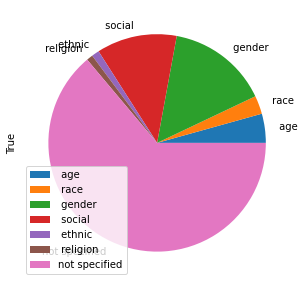

In [380]:
df_counts.plot.pie(y=True, figsize=(5, 5));

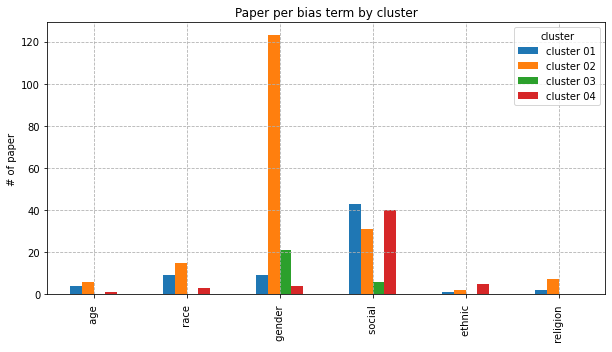

In [338]:
# cluster per bias
def clust_per_bias_plot(this_df, bias_list=bias_list):
    temp_df = pd.DataFrame()

    for i in bias_list:
        temp_df[i] = pd.crosstab(this_df[i],this_df['cluster']).loc[True]

    temp_df.transpose().plot.bar();
    plt.title('Paper per bias term by cluster')
    plt.ylabel("# of paper")
    plt.grid(linestyle='--')

clust_per_bias_plot(df)

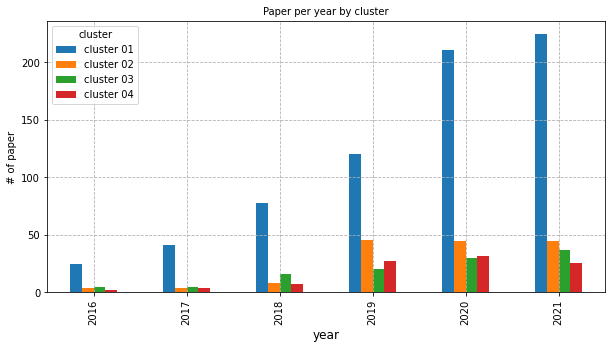

In [318]:
# year per cluster
def year_per_clust_plot(this_df):
    pd.crosstab(this_df['year'],this_df['cluster']).plot.bar();
    plt.title('Paper per year by cluster', fontdict={"fontsize": 10})
    plt.xlabel("year", fontdict={"fontsize": 12})
    plt.ylabel("# of paper")
    plt.grid(linestyle='--')
    
year_per_clust_plot(df)

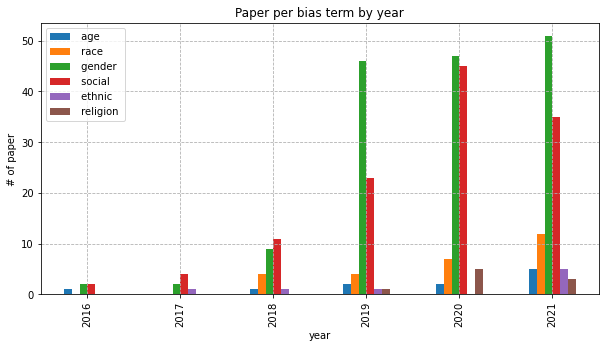

In [339]:
# bias per year
def bias_per_year_plot(this_df, bias_list=bias_list):
    temp_df = pd.DataFrame()

    for i in bias_list:
        temp_df[i] = pd.crosstab(this_df[i],this_df['year']).loc[True]

    temp_df.plot.bar();
    plt.title('Paper per bias term by year')
    plt.ylabel("# of paper")
    plt.grid(linestyle='--')
    
bias_per_year_plot(df)

In [320]:
### LDA with inspiration from here: https://medium.com/analytics-vidhya/topic-modelling-using-lda-aa11ec9bec13#:~:text=Topic%20modelling%20in%20natural%20language%20processing%20is%20a%20technique%20which,important%20to%20categories%20the%20documents.
from sklearn.feature_extraction.text import CountVectorizer

def get_bow(this_df, col, range_min=1, range_max=3, mindf=0.01, maxdf=0.5):
    
    """Returns the count vectorized dataframe based on the arguments
    
    param df(dataframe): dataframe containing the values
    param  d(str): the column name, under which the documents are present
    param range_min(int): smallest n of n-gram wanted
    param range_max(int): largest n of n-gram wanted
    param mindf(int): threshold for common words
    param maxdf(int): threshold for rare words
    
    return cv(CountVectorizer): the count vectorizer
           cv_df(dataframe): dataframe containing the bag of words"""
    
    vectorizer = CountVectorizer(ngram_range=(range_min, range_max), min_df=mindf, max_df=maxdf)
    Z = vectorizer.fit_transform(this_df[col])
    new_df = pd.DataFrame(Z.toarray(), columns = vectorizer.get_feature_names())
    
    return Z, new_df, vectorizer

Z_df, _, cv_df = get_bow(df, 'cleaned_w_title')


In [321]:
# Use LDA to look for 6 topics
from sklearn.decomposition import LatentDirichletAllocation

def make_lda(this_df, Z, vectorizer, n_topics=6):
    model_lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    model_lda.fit(Z)

    # Print the top 10 words per topic
    n_words = 20
    feature_names = vectorizer.get_feature_names()

    topic_list = []
    for topic_idx, topic in enumerate(model_lda.components_):
        top_n = [feature_names[i]
                  for i in topic.argsort()
                   [-n_words:]][::-1]

        top_features = ' '.join(top_n)

        topic_list.append(f"topic_{'_'.join(top_n[:3])}") 

        print(f"Topic {topic_idx}: {top_features}")
        # print('\n')

    topic_result = model_lda.transform(Z)
    this_df['topic']  = topic_result.argmax(axis=1)
    
make_lda(df, Z_df, cv_df, n_topics=5)

Topic 0: gender word embeddings biases gender bias language word embeddings models methods debiasing embedding data show nlp translation machine representations work social words
Topic 1: model models training neural translation learning data language show trained propose based performance machine method machine translation task tasks results pre
Topic 2: news based model data models language task using detection paper text analysis dataset different media sentiment social performance corpus show
Topic 3: de language et les la des language models en le un languages models nlp natural une corpus pour sur du natural language
Topic 4: models evaluation language human dataset question data generation text model systems tasks task datasets based performance metrics natural dialogue knowledge


In [345]:
# TODO
# how do cluster correspond to topic
df_ws = df[df['booktitle'].str.contains('Workshop', na=False)]
df_co = df[df['booktitle'].str.contains('Conference', na=False)]

def main(this_df, data, n_cluster=6, max_words=20, bias_list=bias_list):
    # length of dataframe
    print(f'entries: {len(this_df.index)}')
    
    # create cluster & pca components & print keywords for cluster
    cluster, this_df['cluster'], this_df['x0'], this_df['x1'] = make_pca_vecs(data, n_cluster)
    get_top_keywords(this_df, data, cluster, max_words)
    this_df['cluster'] = this_df['cluster'].map(cluster_map)
    
    # create kmeans plot
    make_kmeans_plot(this_df)
    
    # do one hot encoding & create stats plots
    one_hot(bias_list, this_df)
    clust_per_bias_plot(this_df, bias_list)
    year_per_clust_plot(this_df)
    bias_per_year_plot(this_df, bias_list)
    
    # create lda vectorizer & perform LDA
    Z_df, _, cv_df = get_bow(this_df, 'cleaned_w_title')
    make_lda(this_df, Z_df, cv_df, n_topics=n_cluster)

In [346]:
pd.options.mode.chained_assignment = None  # default='warn'
# create vectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.2, max_features=80)

entries: 279

Cluster 1
level,may,proposed,biased,approach,corpora,provide,training,test,languages,method,english,system,methods,research,many,nlp,translation,processing,machine

Cluster 2
methods,study,proposed,approach,trained,one,research,experiments,classification,present,bert,network,two,features,accuracy,system,biased,media,detection,news

Cluster 3
state,art,domain,set,existing,method,knowledge,user,well,study,recent,datasets,approach,system,question,two,end,human,generation,evaluation

Cluster 4
semantic,set,fine,representation,approach,new,training,find,sentiment,corpus,trained,present,classification,linguistic,annotated,features,datasets,tasks,bert,information

Cluster 5
specific,state,method,trained,training,present,across,words,large,corpora,studies,recent,methods,debiasing,user,study,embedding,media,social,embeddings


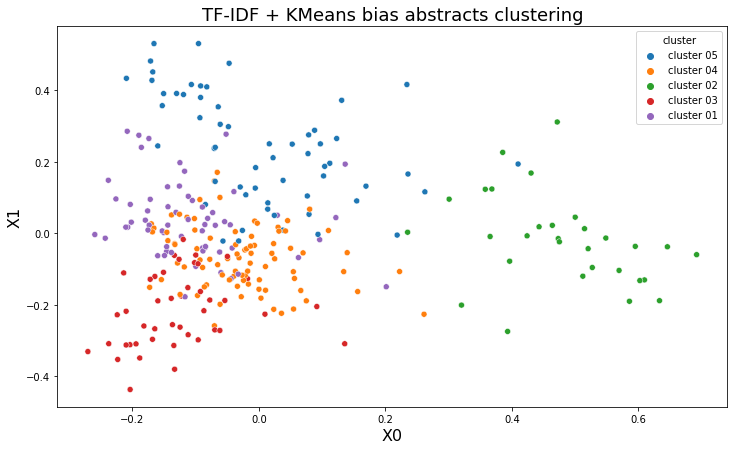

Topic 0: gender language data embeddings word nlp natural gender bias natural language research different processing models paper word embeddings natural language processing language processing methods text languages
Topic 1: gender biases models language social gender bias media word analysis data social media sentiment model dataset embeddings based paper use word embeddings research
Topic 2: models language word dataset based gender biases bert embeddings data datasets neural representations different question natural tasks natural language performance gender bias
Topic 3: model task news based system data learning models neural using approach paper network detection text performance features translation hyperpartisan shared
Topic 4: text language generation model clinical evaluation using systems models data paper learning biases propose linguistic may human generated show recent


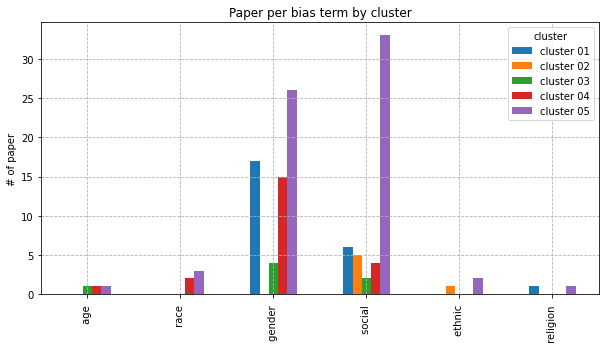

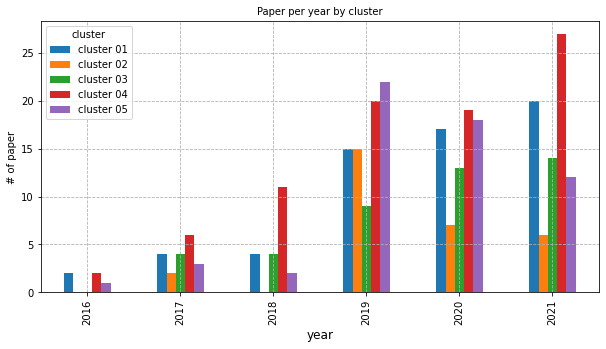

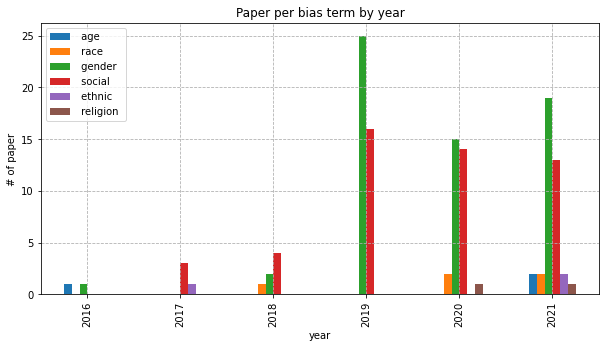

In [347]:
# ONLY LOOK AT WORKSHOP PAPERS
data1 = vectorizer.fit_transform(df_ws['cleaned_w_title'])
main(df_ws, data1, n_cluster=5)

entries: 558

Cluster 1
multiple,improve,study,test,analysis,sentences,novel,often,evaluation,use,system,large,new,research,english,first,corpus,systems,detection,news

Cluster 2
pre,systems,corpora,new,proposed,study,nlp,biased,languages,analysis,across,english,use,words,find,corpus,representations,social,embeddings,gender

Cluster 3
generation,use,metrics,proposed,multi,well,approach,sentences,sentence,inference,attention,level,evaluation,problem,systems,quality,sequence,english,machine,translation

Cluster 4
across,find,corpus,one,set,study,use,inference,languages,entity,experiments,knowledge,representations,nlp,new,large,approach,natural,existing,classification

Cluster 5
level,may,system,learn,proposed,previous,set,test,systems,analysis,sequence,framework,knowledge,semantic,natural,automatic,metrics,evaluation,generation,question


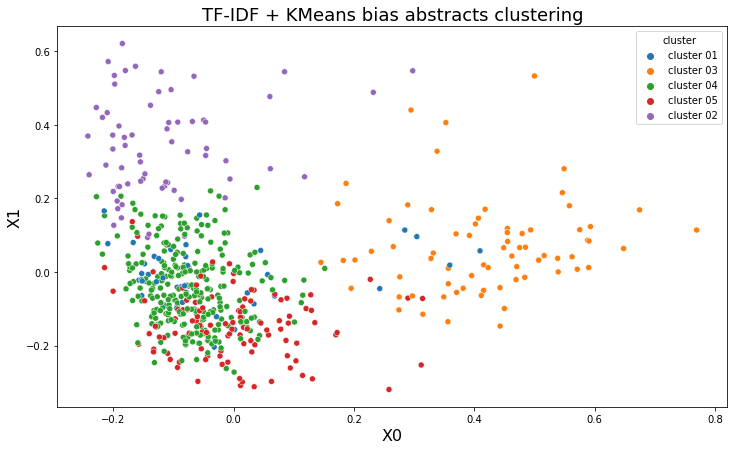

Topic 0: gender word language biases embeddings gender bias task word embeddings text methods dataset show data trained model information work dialogue representations embedding
Topic 1: language model data learning performance tasks natural neural training language models languages datasets linguistic biases natural language based show task state results
Topic 2: news based dataset corpus detection different sentiment analysis media user social articles model paper content annotated emotion task nlp work
Topic 3: translation machine machine translation model training neural evaluation based quality systems language generation summarization human metrics transformer english show sequence neural machine
Topic 4: model data training text question propose learning entity performance method show methods adversarial search paper based knowledge datasets domain set


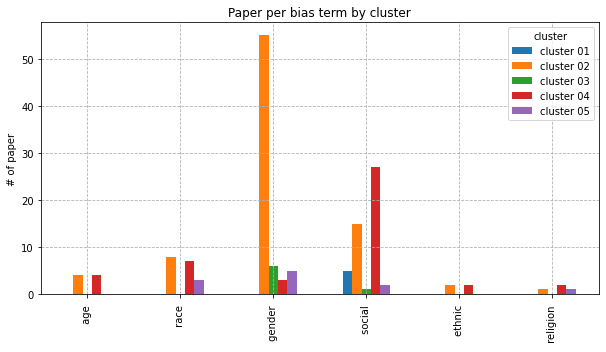

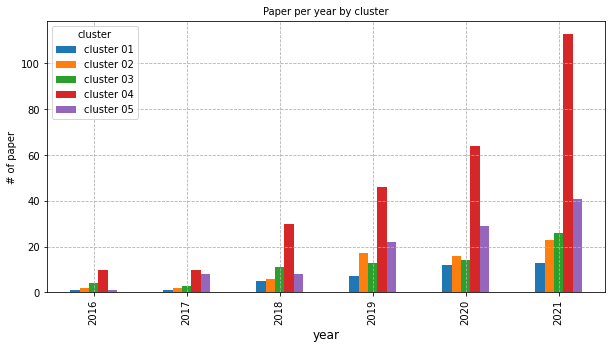

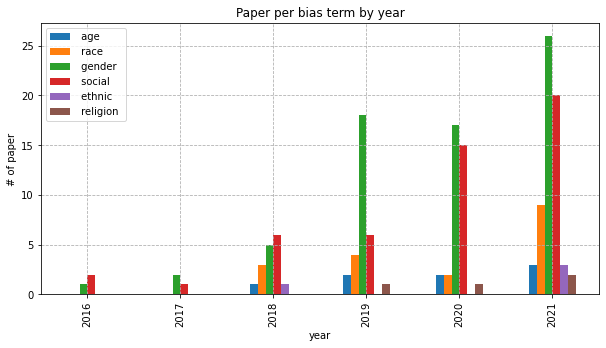

In [348]:
# ONLY LOOK AT CONFERENCE PAPERS
data2 = vectorizer.fit_transform(df_co['cleaned_w_title'])
main(df_co, data2, n_cluster=5)

entries: 120
bias list: [' age ', ' race ', ' gender ', ' ethnic ', ' religion ']

Cluster 1
two,performance,level,network,embedding,information,find,set,sentiment,proposed,stereotypes,neural,debiasing,state,well,training,tasks,task,method,representations

Cluster 2
first,english,state,corpus,users,level,content,multiple,one,stereotypes,introduce,large,scale,use,across,new,datasets,find,groups,demographic

Cluster 3
learning,level,datasets,automatic,processing,proposed,problem,natural,existing,corpus,first,discourse,annotated,content,task,articles,fake,political,detection,news

Cluster 4
corpus,towards,embedding,evaluation,problem,specific,may,approach,one,english,system,tweets,knowledge,systems,machine,translation,often,languages,training,corpora

Cluster 5
two,towards,knowledge,across,learning,first,measure,approach,users,human,evaluation,biased,user,automatic,recent,systems,focus,various,natural,processing


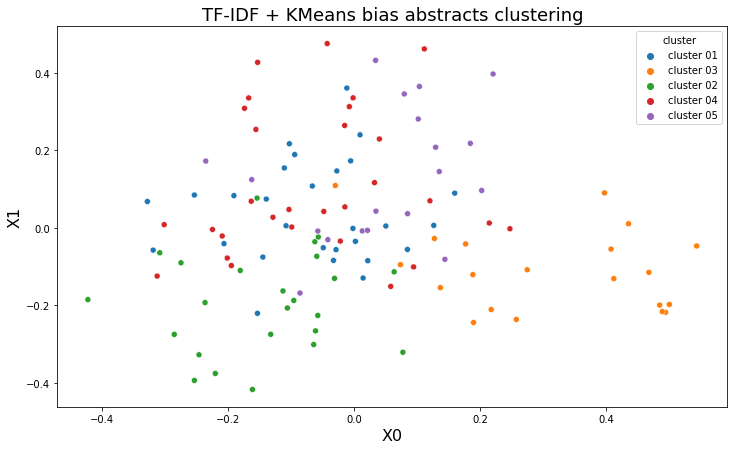

Topic 0: embeddings word biases word embeddings model based language data different methods gender models embedding evidence however measures across datasets work automatic
Topic 1: gender biases word representations gender bias sentence models text social biases work level show image multimodal word representations women implicit based data two
Topic 2: gender biases language models training gender bias data translation machine word embeddings paper tasks community machine translation social bias nlp text propose training data
Topic 3: models media language social media news data based detection model research dataset paper biases learning text corpus fake nlp also task
Topic 4: event media using word news model events based social media gender dataset task gender bias work tweets present methods sentiment nlp corpora


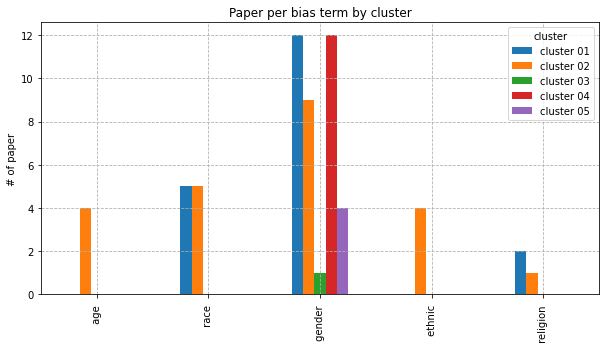

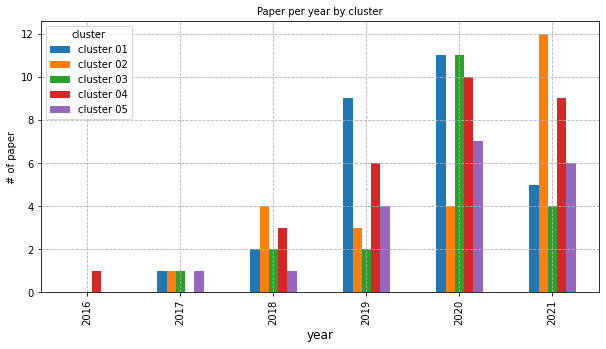

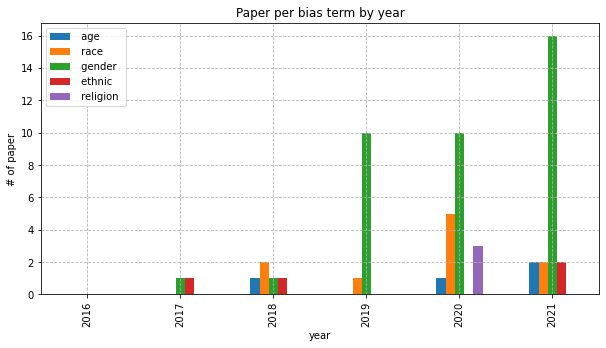

In [343]:
# ONLY LOOK AT PAPERS CONTAINING "SOCIAL"
df_social = df[df['abstract'].str.contains('social', na=False)]
data_social = vectorizer.fit_transform(df_social['cleaned_w_title'])
bias_list_social = [' age ', ' race ', ' gender ', ' ethnic ', ' religion ']
main(df_social, data_social, n_cluster=5, bias_list=bias_list_social)